---------
Clean Data
--------

In [11]:
import numpy as np
from matplotlib import pyplot as plt
import mne, os
import json

with open('C:\\Users\\matil\\Desktop\\FYP\\code_env\\eeg-notebooks\\FYP\\results_data\\Outliers_7030.json', 'r') as file:
    data = json.load(file)
keys_below_30 = []
for key, values in data.items():
    if all(value < 50 for value in values):
        key = key.replace('.json', '.fif')
        keys_below_30.append(key)

to_add = ['VibroVisual_02_2.fif','VibroVisual_03_1.fif','VibroVisual_03_2.fif'] #'VibroVisual_10_2.fif',
for i in to_add:
    keys_below_30.append(i)

print(keys_below_30)
keys_below_30 = ['AudioVisual_04_1.fif', 'AudioVisual_04_2.fif', 'AudioVisual_06_1.fif', 'AudioVisual_06_2.fif',  'ShapeVisual_03_1.fif', 'ShapeVisual_03_2.fif', 'ShapeVisual_04_1.fif', 'ShapeVisual_04_2.fif', 'ShapeVisual_06_2.fif', 'VibroVisual_06_1.fif', 'VibroVisual_02_2.fif', 'VibroVisual_03_1.fif', 'VibroVisual_03_2.fif']

raw_folder = os.path.join(os.path.expanduser('~/'),'Desktop', 'FYP', 'code_env', 'eeg-notebooks','FYP', 'data_ordered', 'mne_raw')
raw_files_all = [file for file in os.listdir(raw_folder) if file.endswith(".fif")]

['AudioVisual_04_1.fif', 'AudioVisual_04_2.fif', 'AudioVisual_06_1.fif', 'AudioVisual_06_2.fif', 'ShapeVisual_01_1.fif', 'ShapeVisual_01_2.fif', 'ShapeVisual_02_2.fif', 'ShapeVisual_03_1.fif', 'ShapeVisual_03_2.fif', 'ShapeVisual_04_1.fif', 'ShapeVisual_04_2.fif', 'ShapeVisual_06_2.fif', 'ShapeVisual_07_2.fif', 'ShapeVisual_09_1.fif', 'ShapeVisual_10_1.fif', 'ShapeVisual_10_2.fif', 'ShapeVisual_11_1.fif', 'ShapeVisual_11_2.fif', 'VibroVisual_06_1.fif', 'VibroVisual_02_2.fif', 'VibroVisual_03_1.fif', 'VibroVisual_03_2.fif']


--------------------------
ERP for all raws, left n right
-------------------------

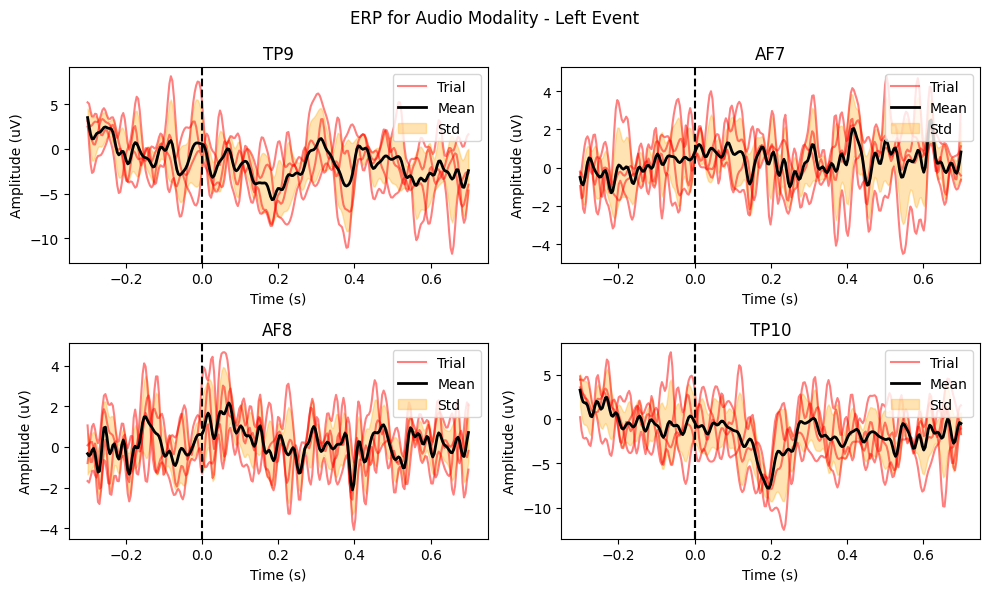

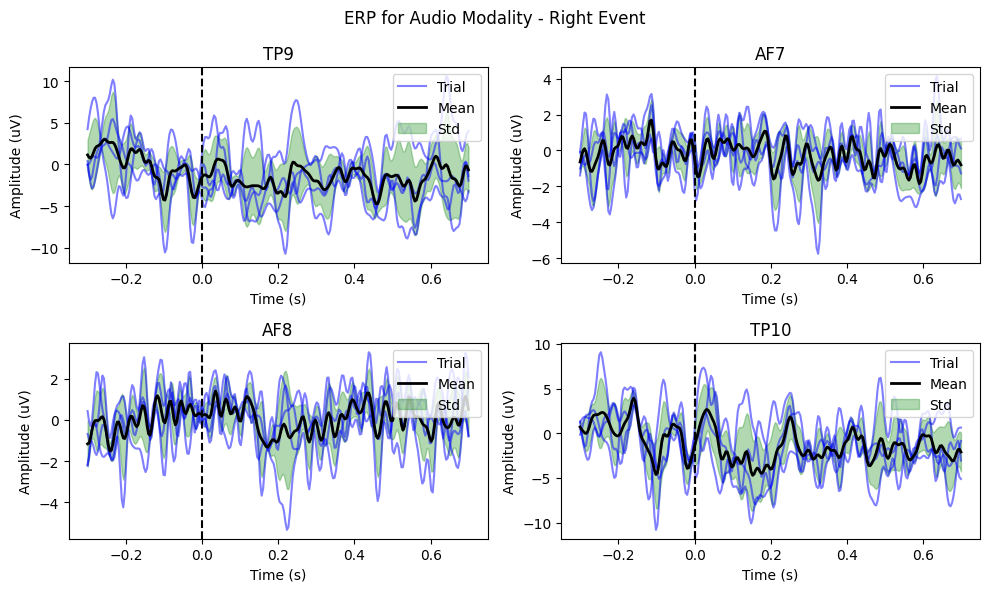

In [16]:
from eeg_analysis_lib import erp_alltrials
import mne

mne.set_log_level("ERROR")
erp_alltrials(keys_below_30, mode= "Audio", rejection_th =70, show_trials=True)


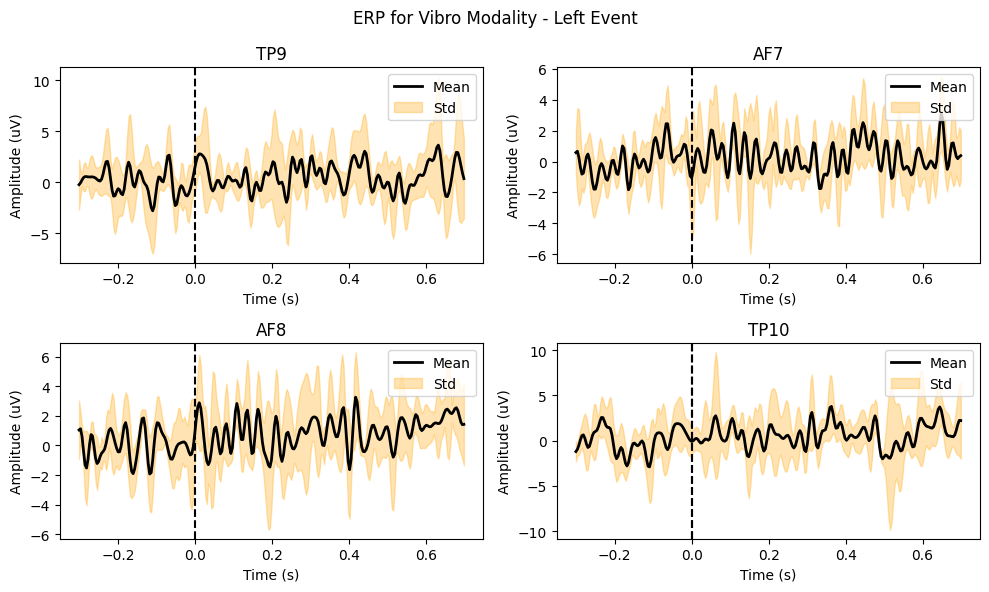

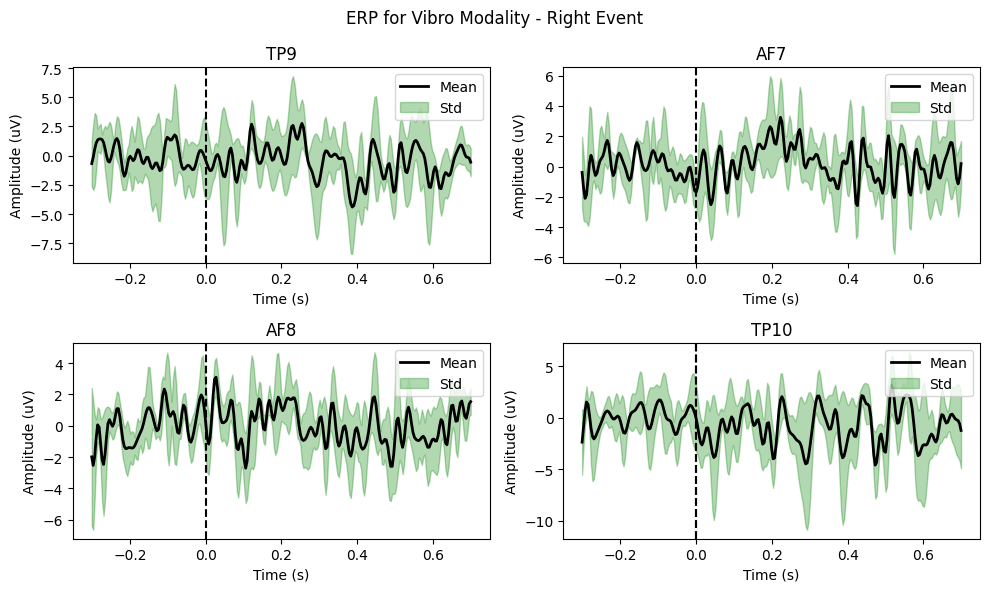

In [28]:
erp_alltrials(keys_below_30, mode= "Vibro", rejection_th =50, show_trials=False)


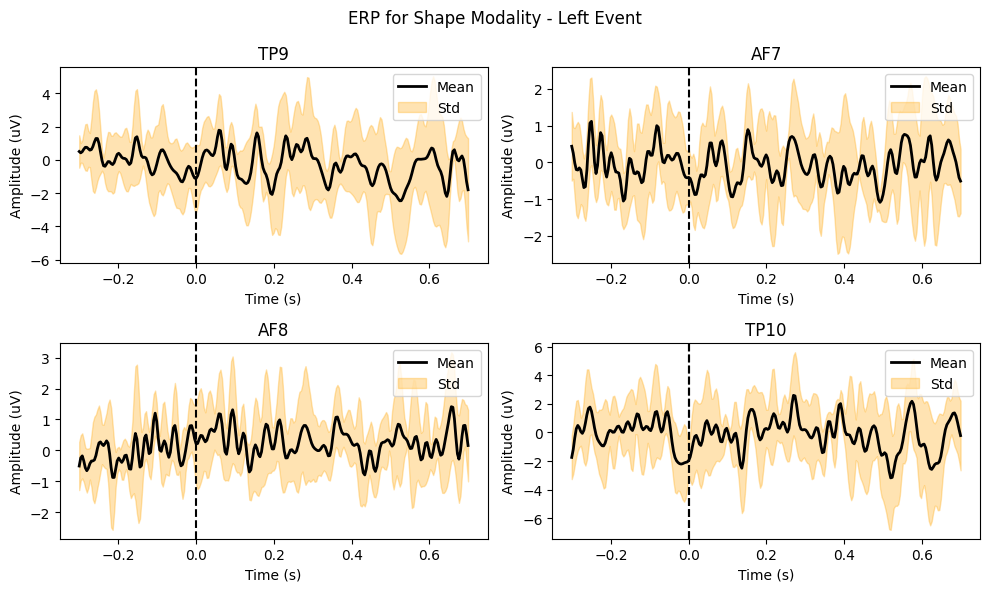

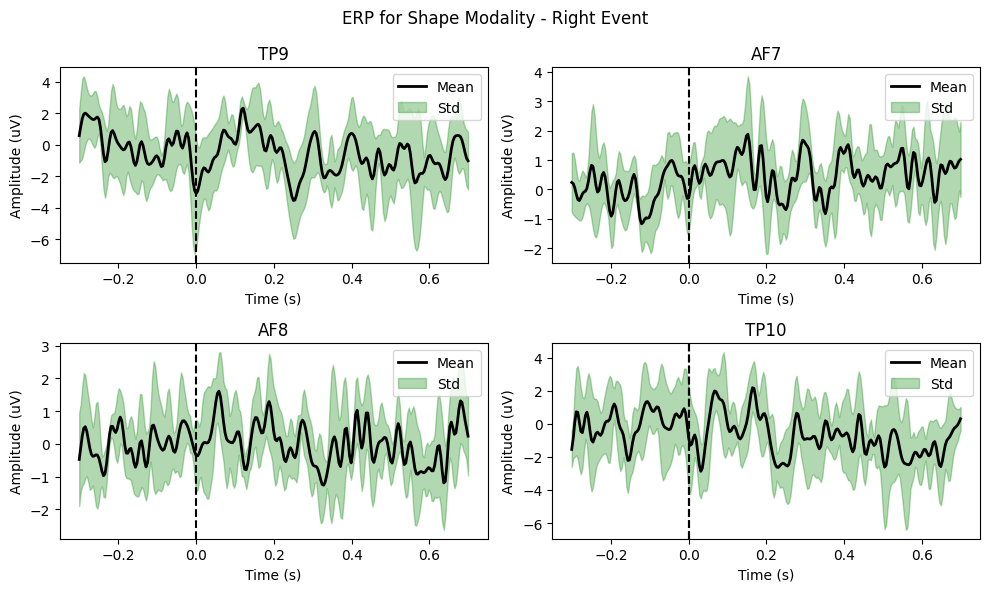

In [30]:
erp_alltrials(keys_below_30, mode= "Shape", rejection_th =70, show_trials=False)

----------------
Audio 1 Participant All Plots
----------

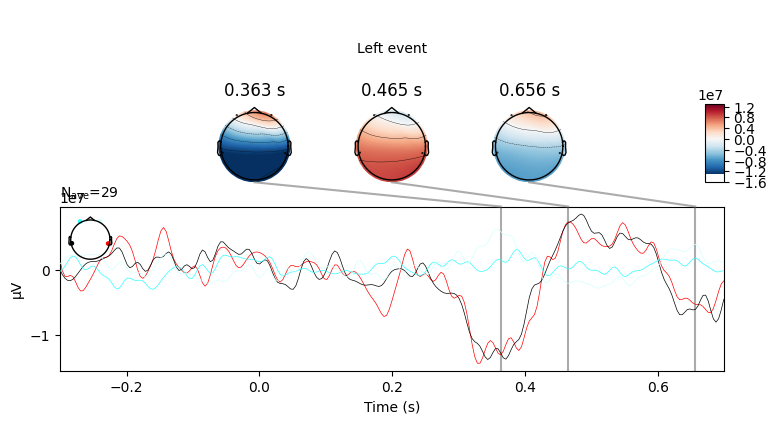

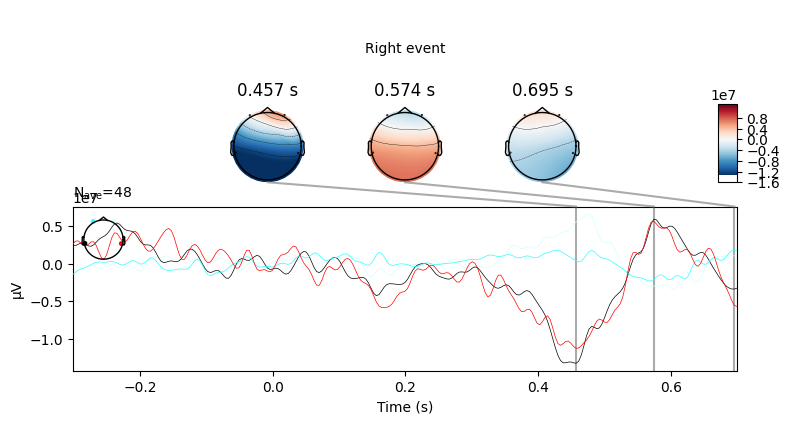

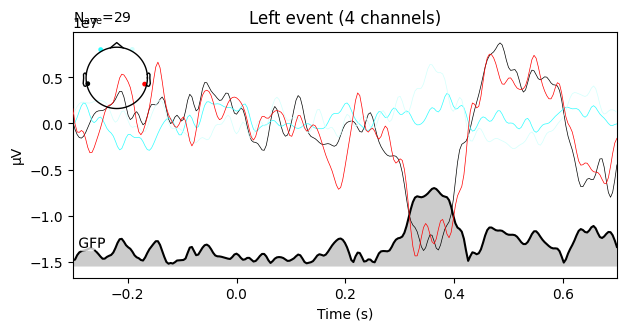

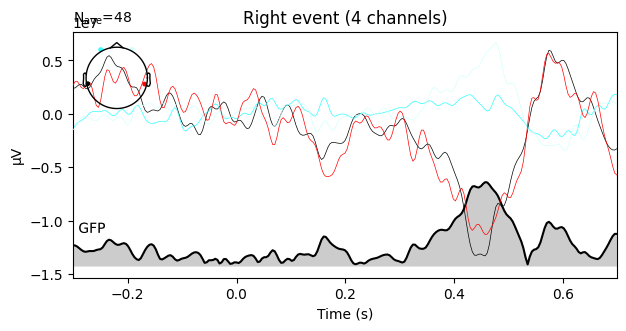

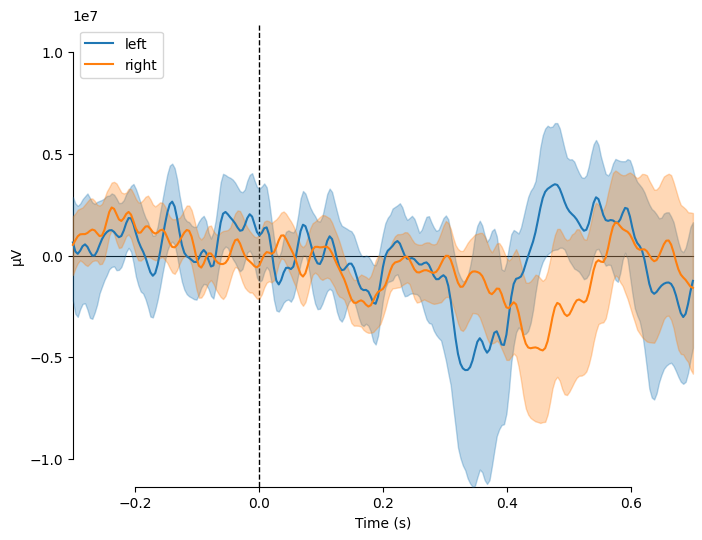

In [10]:
import os, mne
from eeg_analysis_lib import create_raw_object, extract_direction_evoked

mne.set_log_level("ERROR")
epochs = {"left": [], "right": []}
raw_path = os.path.join(os.path.expanduser('~/'), 'Desktop', 'FYP', 'code_env', 'eeg-notebooks', 'FYP', 'data_ordered', 'mne_raw', 'AudioVisual_04_1.fif')
raw  = mne.io.read_raw_fif(raw_path, preload=True)
epochs["left"], epochs["right"] = extract_direction_evoked(raw, plot_display=True)


-------------
Vibro 1 Participant All Plots
-----------

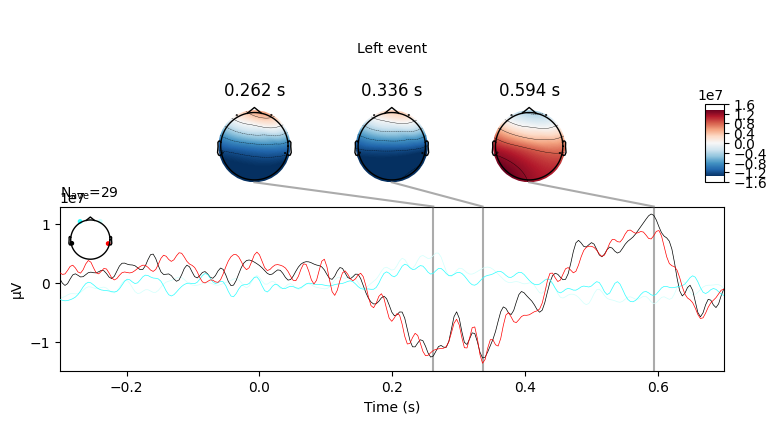

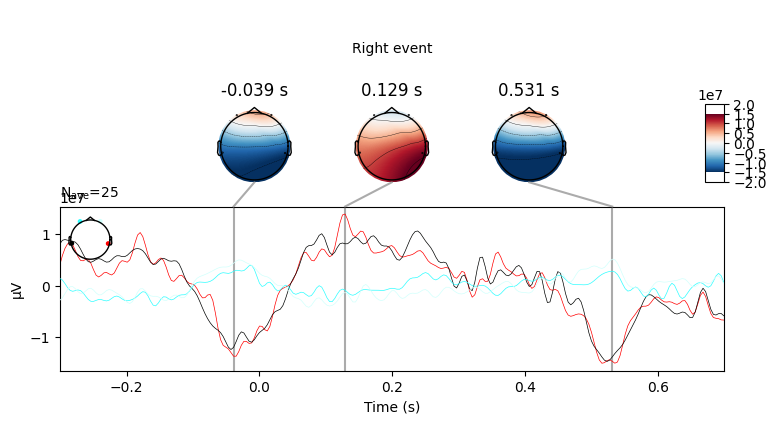

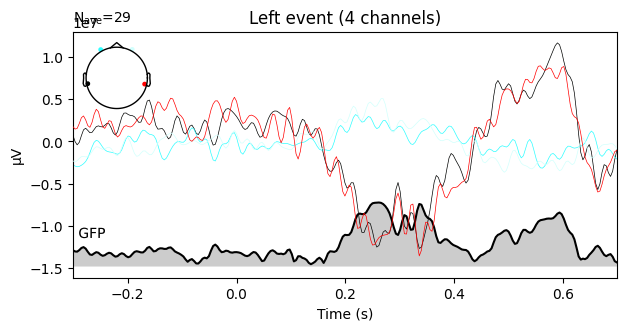

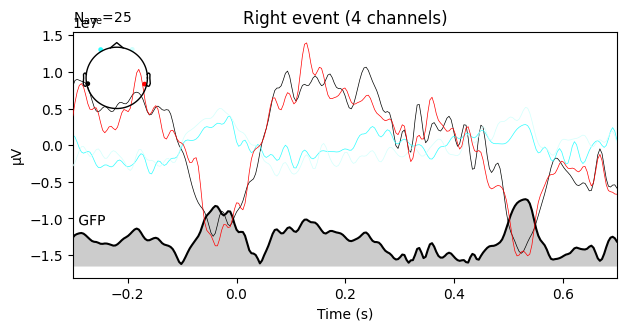

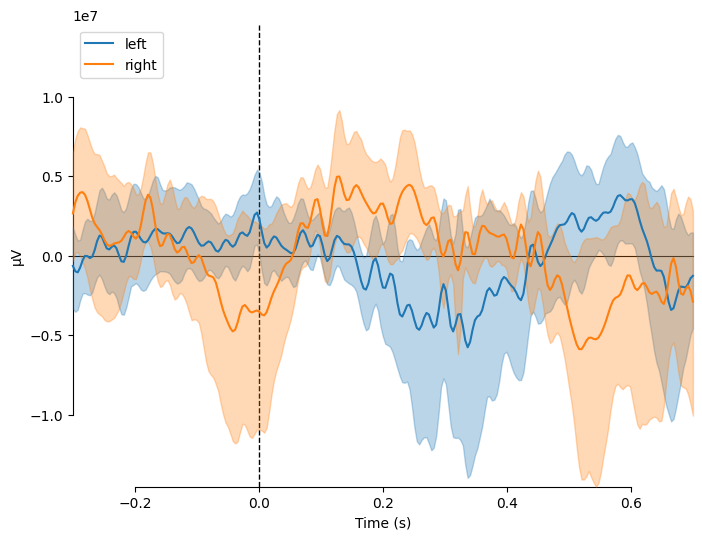

In [9]:
import os, mne
from eeg_analysis_lib import create_raw_object, extract_direction_evoked

mne.set_log_level("ERROR")
epochs = {"left": [], "right": []}
raw_path = os.path.join(os.path.expanduser('~/'), 'Desktop', 'FYP', 'code_env', 'eeg-notebooks', 'FYP', 'data_ordered', 'mne_raw', 'VibroVisual_04_1.fif')
raw  = mne.io.read_raw_fif(raw_path, preload=True)
epochs["left"], epochs["right"] = extract_direction_evoked(raw, plot_display=True)

------------
Shape 1 Participant  All Plots
---------

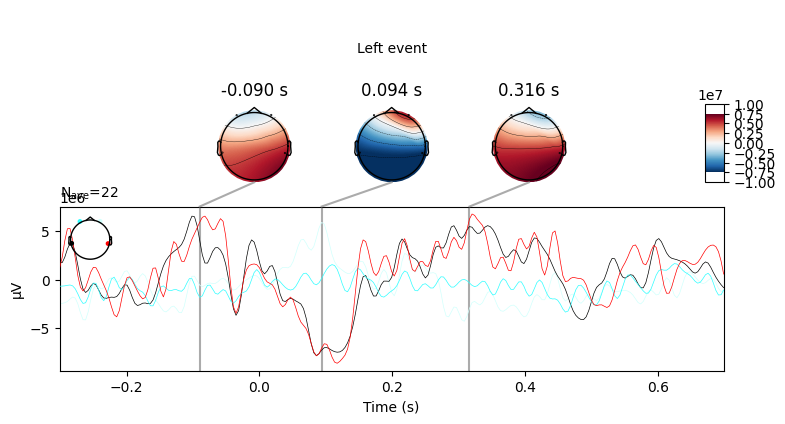

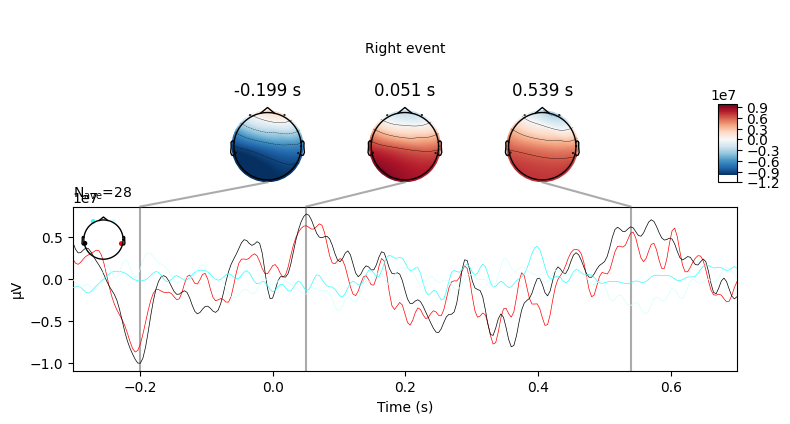

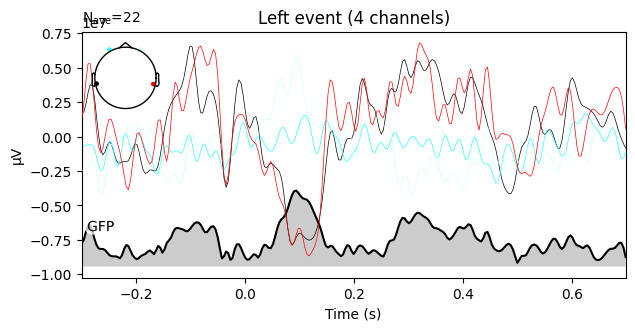

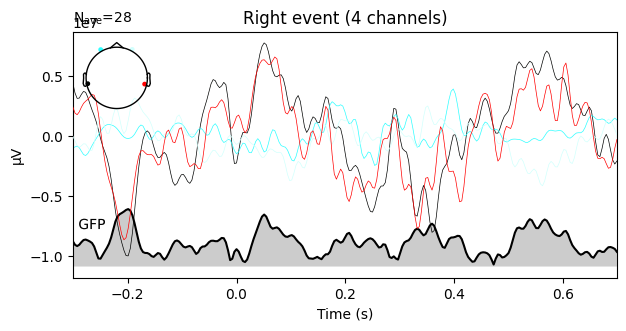

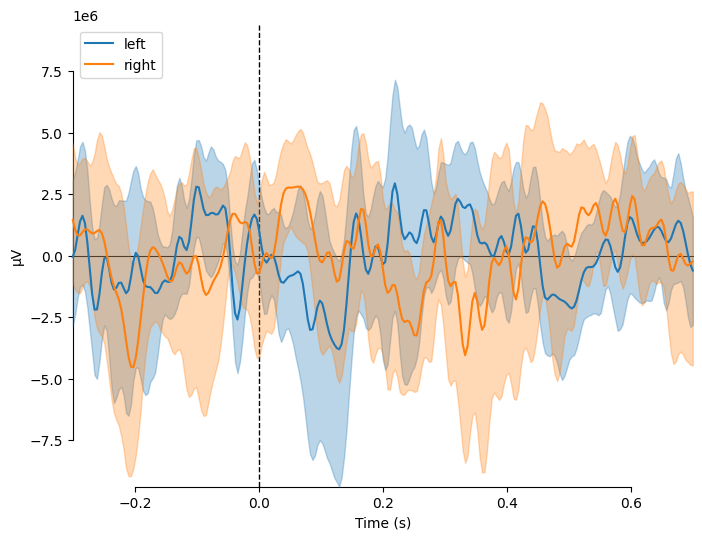

In [8]:
import os, mne
from eeg_analysis_lib import create_raw_object, extract_direction_evoked

mne.set_log_level("ERROR")
epochs = {"left": [], "right": []}
raw_path = os.path.join(os.path.expanduser('~/'), 'Desktop', 'FYP', 'code_env', 'eeg-notebooks', 'FYP', 'data_ordered', 'mne_raw', 'ShapeVisual_04_1.fif')
raw  = mne.io.read_raw_fif(raw_path, preload=True)
epochs["left"], epochs["right"] = extract_direction_evoked(raw, plot_display=True)